# Exploring Dandiset 001333: Parkinson's Electrophysiological Signal Dataset (PESD)

> **DISCLAIMER**: This notebook was AI-generated using dandi-notebook-gen and has not been fully verified. Please be cautious when interpreting the code or results.

This notebook demonstrates how to access, load, and analyze data from the Parkinson's Electrophysiological Signal Dataset (PESD), which contains electrophysiological signals from simulated healthy subjects with beta oscillations. Beta oscillations (13-30 Hz) in the subthalamic nucleus (STN) are typically used as pathological biomarkers for Parkinson's Disease symptoms.

## Introduction to the Dataset

Let's start by exploring the metadata of this Dandiset to understand what it contains.

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py
import remfile
import pynwb
from dandi.dandiapi import DandiAPIClient
from scipy import signal
import seaborn as sns
import os

# Set the seed for reproducibility
np.random.seed(42)

# Configure matplotlib for better visualization
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

### Getting Dandiset Metadata

Let's retrieve the metadata for Dandiset 001333 using the DANDI API.

In [2]:
# Initialize the DANDI API client and get the Dandiset
client = DandiAPIClient()
dandiset = client.get_dandiset("001333")

# Display basic information about the Dandiset
print(f"Dandiset ID: {dandiset.identifier}")
print(f"Version: {dandiset.version}")

# Define a helper function to print available attributes
def print_dict_attr(obj, attr_name):
    if hasattr(obj, attr_name):
        value = getattr(obj, attr_name)
        if isinstance(value, (list, tuple)):
            print(f"\n{attr_name.capitalize()}:")
            for item in value:
                print(f"- {item}")
        else:
            print(f"\n{attr_name.capitalize()}: {value}")
    else:
        print(f"\n{attr_name.capitalize()}: Not available")

# Print dandiset information
print_dict_attr(dandiset, "name")
print_dict_attr(dandiset, "description")
print_dict_attr(dandiset, "contributor")
print_dict_attr(dandiset, "license")
print_dict_attr(dandiset, "keywords")

Dandiset ID: 001333


Version: 0.250327.2220

Name: Not available

Description: Not available

Contributor: Not available

License: Not available

Keywords: Not available


### Getting Assets (Files) in the Dandiset

Now, let's list the assets (files) available in the Dandiset.

In [3]:
# Load the assets information from our previously saved file
import json
with open("assets.json", "r") as f:
    assets_info = json.load(f)

total_assets = assets_info['results']['count']
asset_list = assets_info['results']['results']
    
print(f"Total number of assets: {total_assets}")

# Create a DataFrame to display asset information
asset_data = []
for i, asset in enumerate(asset_list[:20]):  # Display first 20 assets
    asset_data.append({
        'Asset ID': asset['asset_id'],
        'Path': asset['path'],
        'Size (bytes)': asset['size']
    })

asset_df = pd.DataFrame(asset_data)
asset_df

Total number of assets: 1305


,Asset ID,Path,Size (bytes)
0,1d94c7ad-dbaf-43ea-89f2-1b2518fab158,sub-healthy-simulated-beta/sub-healthy-simulat...,225936
1,e0fa57b2-02a4-4c20-92df-d7eb64b60170,sub-healthy-simulated-beta/sub-healthy-simulat...,225936
2,7e145df2-0510-4e6b-8742-f554bf0377db,sub-healthy-simulated-beta/sub-healthy-simulat...,225936
3,945ddecb-afa5-4531-ad6a-ed92d5425817,sub-healthy-simulated-beta/sub-healthy-simulat...,225936
4,209d6d4d-59fb-4496-a46c-b989bbf35a77,sub-healthy-simulated-beta/sub-healthy-simulat...,225936
5,82c72c37-a008-4d78-9912-45dcdb78ffb5,sub-healthy-simulated-beta/sub-healthy-simulat...,225936
6,8d3641e4-1f1f-4b20-9b5e-28d8a3023ecb,sub-healthy-simulated-beta/sub-healthy-simulat...,225936
7,0a94eef1-9c29-4cc7-b115-51d623a076d1,sub-healthy-simulated-beta/sub-healthy-simulat...,225936
8,8009eb30-ca64-4474-8885-0a808dabdd17,sub-healthy-simulated-beta/sub-healthy-simulat...,225936
9,e8370b8d-1615-46cc-9d5c-7198f74e4e79,sub-healthy-simulated-beta/sub-healthy-simulat...,225936


### Exploring File Types and Organization

Let's analyze the file organization to understand the structure of the dataset.

In [4]:
# Extract subject and session information from file paths
subject_types = set()
subject_sessions = {}

for asset in asset_list:
    parts = asset['path'].split('/')
    if len(parts) >= 1:
        subject = parts[0]
        subject_types.add(subject)
        
        # Extract session ID from filename
        if len(parts) >= 2:
            filename = parts[1]
            if '_ses-' in filename:
                session = filename.split('_ses-')[1].split('_')[0]
                if subject not in subject_sessions:
                    subject_sessions[subject] = []
                subject_sessions[subject].append(session)

print("Subject types in the dataset:")
for subject in subject_types:
    print(f"- {subject}")

print("\nNumber of sessions per subject type:")
for subject, sessions in subject_sessions.items():
    print(f"- {subject}: {len(set(sessions))} unique sessions")

Subject types in the dataset:
- sub-healthy-simulated-beta

Number of sessions per subject type:
- sub-healthy-simulated-beta: 20 unique sessions


## Loading and Exploring NWB Files

Now let's select a few NWB files and explore their contents to understand the data structure.

In [5]:
# Select a few files to analyze
selected_assets = asset_list[:3]  # First 3 assets for demonstration
selected_files = []

for asset in selected_assets:
    selected_files.append({
        'asset_id': asset['asset_id'],
        'path': asset['path'],
        'url': f"https://api.dandiarchive.org/api/assets/{asset['asset_id']}/download/"
    })

selected_files_df = pd.DataFrame(selected_files)
selected_files_df

,asset_id,path,url
0,1d94c7ad-dbaf-43ea-89f2-1b2518fab158,sub-healthy-simulated-beta/sub-healthy-simulat...,https://api.dandiarchive.org/api/assets/1d94c7...
1,e0fa57b2-02a4-4c20-92df-d7eb64b60170,sub-healthy-simulated-beta/sub-healthy-simulat...,https://api.dandiarchive.org/api/assets/e0fa57...
2,7e145df2-0510-4e6b-8742-f554bf0377db,sub-healthy-simulated-beta/sub-healthy-simulat...,https://api.dandiarchive.org/api/assets/7e145d...


### Exploring the Structure of an NWB File

Let's open the first NWB file and examine its structure to understand what data is available.

In [6]:
# Load the first NWB file
url = selected_files[0]['url']
file = remfile.File(url)
f = h5py.File(file)
io = pynwb.NWBHDF5IO(file=f)
nwb = io.read()

# Display basic information about the file
print(f"Session Description: {nwb.session_description}")
print(f"Identifier: {nwb.identifier}")
print(f"Session Start Time: {nwb.session_start_time}")
print(f"Lab: {nwb.lab}")
print(f"Institution: {nwb.institution}")
print(f"Experimenters: {', '.join(nwb.experimenter)}")
print(f"Related Publications: {', '.join(nwb.related_publications)}")

# Display keywords
print("\nKeywords:")
keywords = nwb.keywords[:]
for keyword in keywords:
    print(f"- {keyword}")

# Display subject information
subject = nwb.subject
print("\nSubject Information:")
print(f"Subject ID: {subject.subject_id}")
print(f"Species: {subject.species}")
print(f"Sex: {subject.sex}")
print(f"Age: {subject.age}")
print(f"Description: {subject.description}")

Session Description: Parkinson's Electrophysiological Signal Dataset (PESD) Generated from Simulation
Identifier: 84828db4-a3a3-4b2e-abff-6db2b404dd68
Session Start Time: 2025-04-03 12:30:26.094607-04:00
Lab: BrainX Lab
Institution: Michigan Technological University
Experimenters: Ananna Biswas
Related Publications: https://arxiv.org/abs/2407.17756, DOI: 10.3389/fnins.2020.00166

Keywords:
- ecephys
- LFP
- Parkinson's Disease
- Beta Band

Subject Information:
Subject ID: healthy-simulated-beta
Species: Homo sapiens
Sex: U
Age: P0D
Description: This is a simulated dataset generated from a computational model.


/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.8.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


### Examining Electrode Groups

Let's look at the electrode groups in the file.

In [7]:
# Display electrode group information
print("Electrode Groups:")
for group_name, group in nwb.electrode_groups.items():
    print(f"\nGroup: {group_name}")
    print(f"Description: {group.description}")
    print(f"Location: {group.location}")
    print(f"Device: {group.device}")
    print(f"Device Description: {group.device.description}")
    print(f"Device Manufacturer: {group.device.manufacturer}")

Electrode Groups:

Group: shank0
Description: Simulated electrode group for shank 0
Location: Simulated Cortico-basal-ganglia network of brain
Device: NEURON_Simulator pynwb.device.Device at 0x133323926031344
Fields:
  description: Virtual probe used in NEURON simulation
  manufacturer: N/A

Device Description: Virtual probe used in NEURON simulation
Device Manufacturer: N/A

Group: shank1
Description: Simulated electrode group for shank 1
Location: Simulated Cortico-basal-ganglia network of brain
Device: NEURON_Simulator pynwb.device.Device at 0x133323926031344
Fields:
  description: Virtual probe used in NEURON simulation
  manufacturer: N/A

Device Description: Virtual probe used in NEURON simulation
Device Manufacturer: N/A

Group: shank2
Description: Simulated electrode group for shank 2
Location: Simulated Cortico-basal-ganglia network of brain
Device: NEURON_Simulator pynwb.device.Device at 0x133323926031344
Fields:
  description: Virtual probe used in NEURON simulation
  manufa

### Exploring the Available Data

Now, let's look at the data interfaces and electrical series available in the file.

In [8]:
# Display information about the processing module
print("Processing Module:")
for module_name, module in nwb.processing.items():
    print(f"\nModule: {module_name}")
    print(f"Description: {module.description}")
    
    # Display the data interfaces
    print("\nData Interfaces:")
    for interface_name, interface in module.data_interfaces.items():
        print(f"Interface: {interface_name}")
        
        # If this is an LFP interface, display the electrical series
        if interface_name == "LFP":
            print("\nElectrical Series:")
            for series_name, series in interface.electrical_series.items():
                print(f"\nSeries: {series_name}")
                print(f"Unit: {series.unit}")
                print(f"Resolution: {series.resolution}")
                print(f"Conversion: {series.conversion}")
                print(f"Data shape: {series.data.shape}")
                print(f"Timestamps shape: {series.timestamps.shape}")
                print(f"Timestamps unit: {series.timestamps_unit}")

Processing Module:

Module: ecephys
Description: Processed electrophysiology data

Data Interfaces:
Interface: LFP

Electrical Series:

Series: Beta_Band_Voltage
Unit: volts
Resolution: -1.0
Conversion: 1.0
Data shape: (1400,)
Timestamps shape: (1400,)
Timestamps unit: seconds


## Data Analysis and Visualization

Now that we understand the structure of the data, let's load some example data and visualize it.

### Loading LFP Data from a Single File

First, let's load the Beta Band Voltage data from the first file and plot it.

In [9]:
# Function to load data from an NWB file
def load_nwb_data(url):
    file = remfile.File(url)
    f = h5py.File(file)
    io = pynwb.NWBHDF5IO(file=f)
    nwb = io.read()
    
    # Get the Beta Band Voltage data and timestamps
    lfp_data = nwb.processing["ecephys"].data_interfaces["LFP"].electrical_series["Beta_Band_Voltage"].data[:]
    timestamps = nwb.processing["ecephys"].data_interfaces["LFP"].electrical_series["Beta_Band_Voltage"].timestamps[:]
    
    return {
        'nwb': nwb,
        'lfp_data': lfp_data,
        'timestamps': timestamps,
        'subject_id': nwb.subject.subject_id,
        'session_id': nwb.identifier
    }

# Load data from the first file
data1 = load_nwb_data(selected_files[0]['url'])

# Display information about the loaded data
print(f"Subject ID: {data1['subject_id']}")
print(f"Session ID: {data1['session_id']}")
print(f"LFP Data Shape: {data1['lfp_data'].shape}")
print(f"Timestamps Shape: {data1['timestamps'].shape}")
print(f"Time Range: {data1['timestamps'][0]:.2f} to {data1['timestamps'][-1]:.2f} seconds")

Subject ID: healthy-simulated-beta
Session ID: 84828db4-a3a3-4b2e-abff-6db2b404dd68
LFP Data Shape: (1400,)
Timestamps Shape: (1400,)
Time Range: 10.02 to 38.00 seconds


### Visualizing LFP Data

Let's plot the LFP data to visualize the beta oscillations.

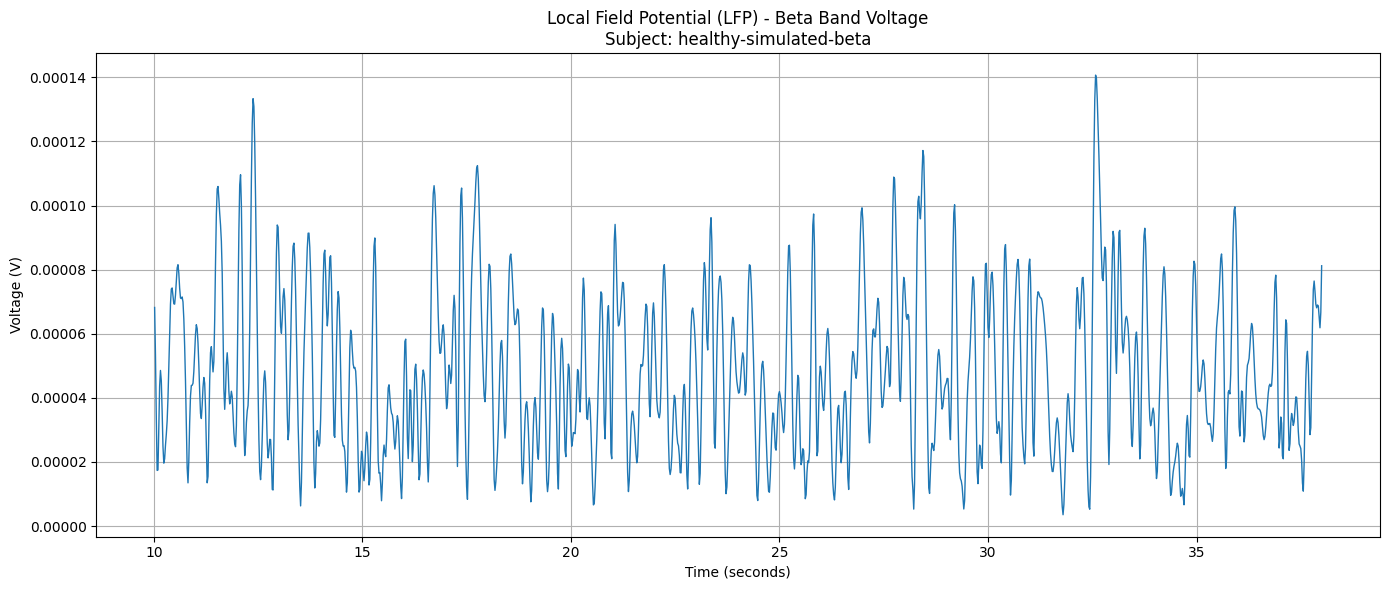

In [10]:
# Plot the LFP data
plt.figure(figsize=(14, 6))
plt.plot(data1['timestamps'], data1['lfp_data'], linewidth=1)
plt.xlabel('Time (seconds)')
plt.ylabel('Voltage (V)')
plt.title(f'Local Field Potential (LFP) - Beta Band Voltage\nSubject: {data1["subject_id"]}')
plt.grid(True)
plt.tight_layout()
plt.show()

### Frequency Analysis of the LFP Data

Let's compute and visualize the power spectral density (PSD) of the LFP data to examine the frequency components.

Estimated sampling frequency: 50.00 Hz


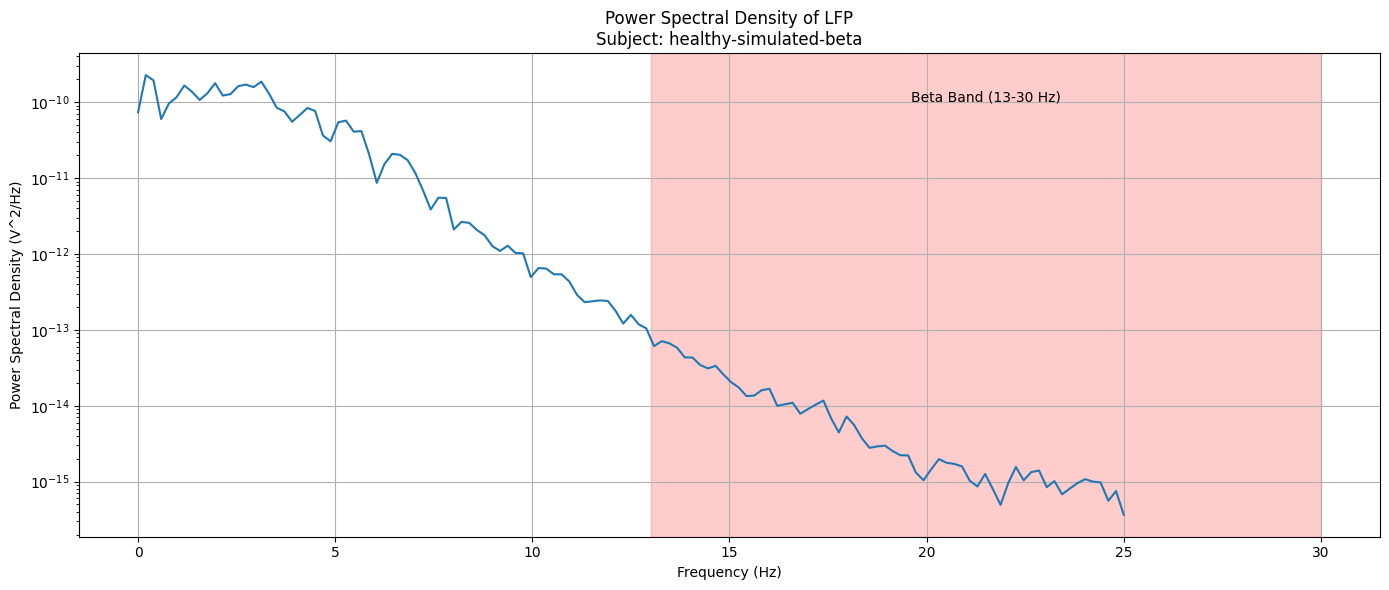

In [11]:
# Compute the Power Spectral Density
def compute_psd(data, fs):
    # Calculate sampling frequency based on timestamps
    f, psd = signal.welch(data, fs, nperseg=256)
    return f, psd

# Calculate sampling frequency from timestamps
ts = data1['timestamps']
fs = 1 / np.mean(np.diff(ts))
print(f"Estimated sampling frequency: {fs:.2f} Hz")

# Compute PSD
f, psd = compute_psd(data1['lfp_data'], fs)

# Plot the PSD
plt.figure(figsize=(14, 6))
plt.semilogy(f, psd)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density (V^2/Hz)')
plt.title(f'Power Spectral Density of LFP\nSubject: {data1["subject_id"]}')
plt.axvspan(13, 30, alpha=0.2, color='red')
plt.text(21.5, np.max(psd)/2, 'Beta Band (13-30 Hz)', 
         horizontalalignment='center', verticalalignment='center')
plt.grid(True)
plt.tight_layout()
plt.show()

We can see from the PSD plot that there's significant power in the beta frequency band (13-30 Hz), which is highlighted in red. This is expected as the dataset contains simulated beta oscillations that mimic patterns seen in Parkinson's Disease.

### Time-Frequency Analysis

Let's perform a time-frequency analysis using a spectrogram to see how the frequency content changes over time.

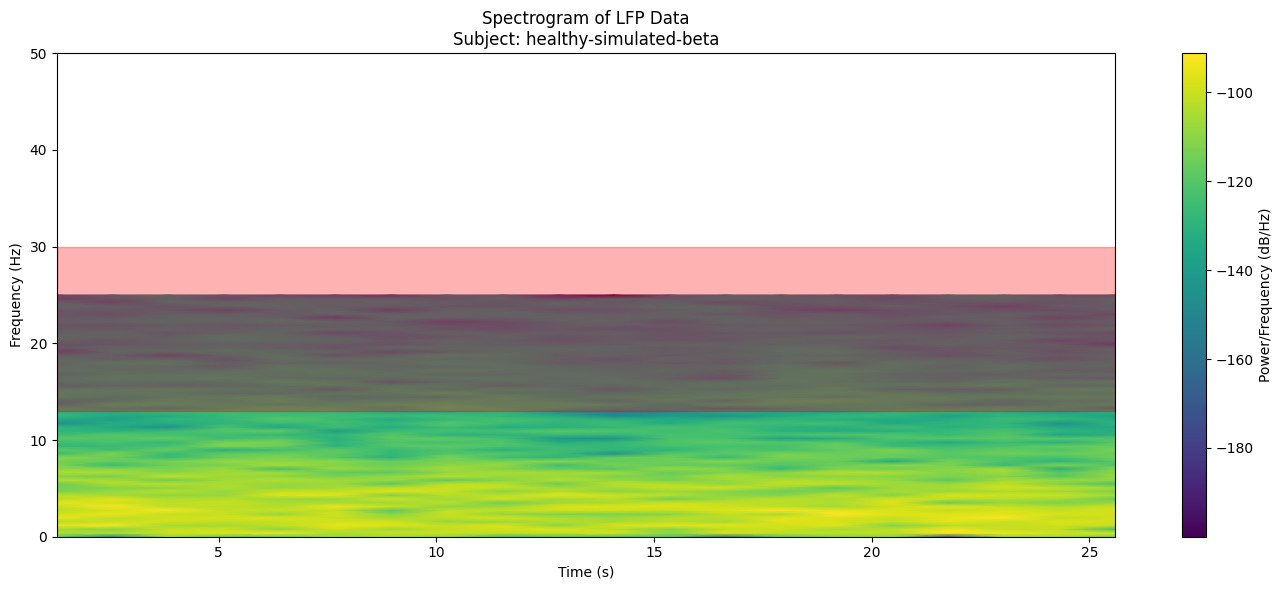

In [12]:
# Time-frequency analysis using spectrogram
def plot_spectrogram(data, fs, title):
    f, t, Sxx = signal.spectrogram(data, fs, nperseg=128, noverlap=64)
    
    plt.figure(figsize=(14, 6))
    plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading='gouraud')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')
    plt.title(title)
    plt.colorbar(label='Power/Frequency (dB/Hz)')
    
    # Highlight beta band (13-30 Hz)
    plt.axhspan(13, 30, alpha=0.3, color='red')
    plt.ylim(0, 50)
    plt.tight_layout()
    plt.show()

# Plot the spectrogram
plot_spectrogram(data1['lfp_data'], fs, 
                f'Spectrogram of LFP Data\nSubject: {data1["subject_id"]}')

The spectrogram shows the power distribution across different frequencies over time. The beta band (13-30 Hz) is highlighted in red, showing the sustained beta oscillations throughout the recording period.

### Comparing Multiple Sessions

Now, let's load data from multiple files and compare them to see if there are differences in the beta oscillation patterns.

In [13]:
# Load data from multiple files
data_list = []
for file_info in selected_files[:3]:  # Use first 3 files
    try:
        data = load_nwb_data(file_info['url'])
        data_list.append(data)
        print(f"Loaded data from {file_info['path']}")
    except Exception as e:
        print(f"Error loading {file_info['path']}: {e}")

Loaded data from sub-healthy-simulated-beta/sub-healthy-simulated-beta_ses-1044_ecephys.nwb


Loaded data from sub-healthy-simulated-beta/sub-healthy-simulated-beta_ses-1046_ecephys.nwb


Loaded data from sub-healthy-simulated-beta/sub-healthy-simulated-beta_ses-1070_ecephys.nwb


### Comparing Beta Power Across Sessions

Let's calculate the beta power for each session and compare them.

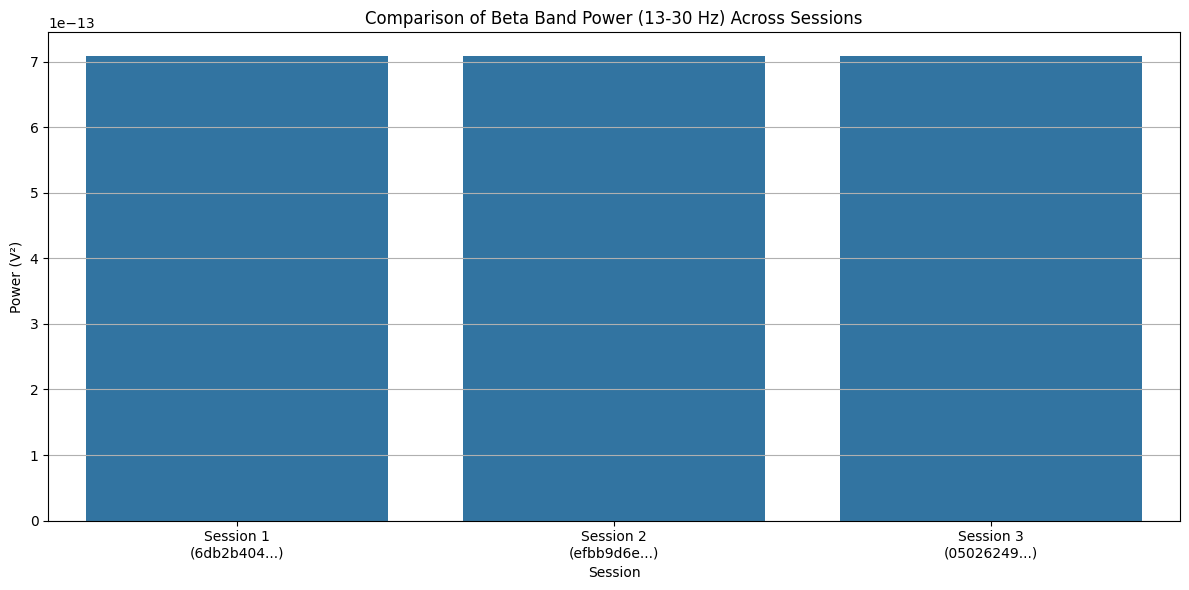

In [14]:
# Calculate beta power for multiple sessions
beta_powers = []

for idx, data in enumerate(data_list):
    # Calculate sampling frequency
    ts = data['timestamps']
    fs = 1 / np.mean(np.diff(ts))
    
    # Compute PSD
    f, psd = compute_psd(data['lfp_data'], fs)
    
    # Calculate beta power (13-30 Hz)
    beta_indices = (f >= 13) & (f <= 30)
    beta_power = np.sum(psd[beta_indices])
    
    # Store information
    session_id = data['session_id'].split('-')[-1] if '-' in data['session_id'] else data['session_id']
    beta_powers.append({
        'Session': f"Session {idx+1}\n({session_id[:8]}...)",
        'Beta Power': beta_power
    })

# Create a DataFrame for plotting
beta_df = pd.DataFrame(beta_powers)

# Plot beta power comparison
plt.figure(figsize=(12, 6))
sns.barplot(x='Session', y='Beta Power', data=beta_df)
plt.title('Comparison of Beta Band Power (13-30 Hz) Across Sessions')
plt.ylabel('Power (V²)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Visualizing LFP Waveforms from Multiple Sessions

Let's plot the LFP data from multiple sessions to visually compare the waveforms.

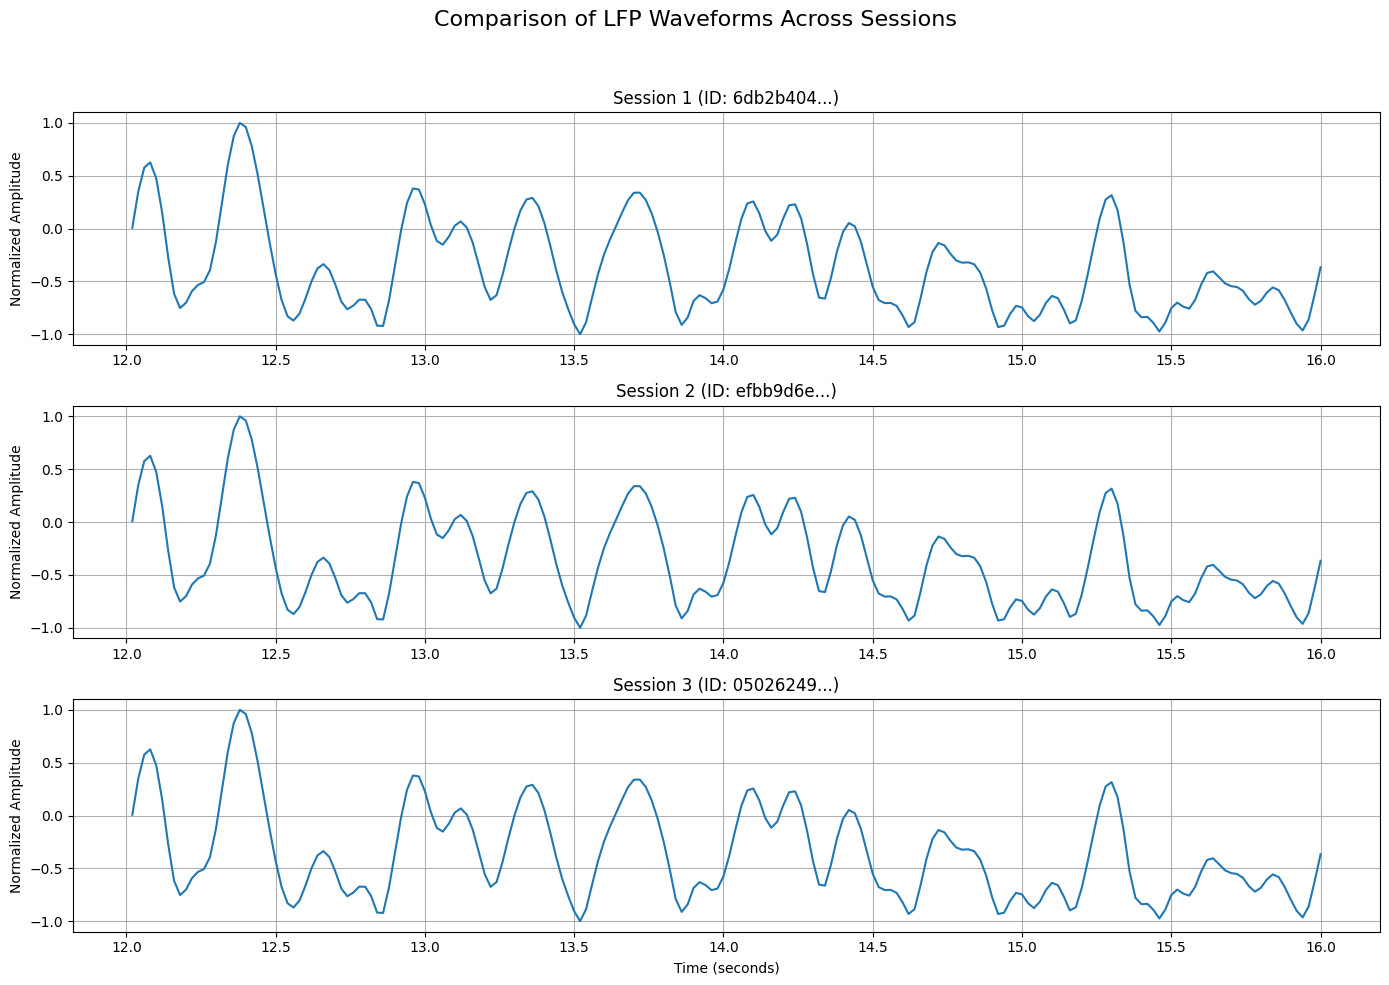

In [15]:
# Plot LFP data from multiple sessions
plt.figure(figsize=(14, 10))

for idx, data in enumerate(data_list):
    session_id = data['session_id'].split('-')[-1] if '-' in data['session_id'] else data['session_id']
    
    # Get a 2-second window of data for clearer visualization
    if len(data['timestamps']) > 200:
        start_idx = 100  # Start after 100 samples to avoid edge effects
        window_size = 200  # Use 200 samples for visualization
        end_idx = start_idx + window_size
        
        time_window = data['timestamps'][start_idx:end_idx]
        data_window = data['lfp_data'][start_idx:end_idx]
        
        # Normalize to the [-1, 1] range for easier comparison
        normalized_data = 2 * (data_window - np.min(data_window)) / (np.max(data_window) - np.min(data_window)) - 1
        
        # Plot with offset for clarity
        plt.subplot(3, 1, idx+1)
        plt.plot(time_window, normalized_data)
        plt.title(f'Session {idx+1} (ID: {session_id[:8]}...)')
        plt.ylabel('Normalized Amplitude')
        
        # Only add x-label for the bottom plot
        if idx == len(data_list) - 1:
            plt.xlabel('Time (seconds)')
        
        plt.grid(True)

plt.suptitle('Comparison of LFP Waveforms Across Sessions', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust for the suptitle
plt.show()

### Beta Band Filtering and Envelope

Let's apply a bandpass filter to isolate the beta frequencies and compute the envelope to visualize the beta power fluctuations over time.

In [16]:
# Function to filter signal and compute envelope
def filter_and_envelope(data, fs, lowcut, highcut):
    # Design bandpass filter
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    
    # Make sure frequencies are in valid range (0, 1)
    low = max(0.001, min(0.999, low))
    high = max(0.001, min(0.999, high))
    
    # Ensure low < high
    if low >= high:
        low = 0.1
        high = 0.4
        print(f"Warning: Invalid frequency range. Using default range: {low*nyquist:.2f}-{high*nyquist:.2f} Hz")
    
    order = 4
    b, a = signal.butter(order, [low, high], btype='band')
    
    # Apply filter
    filtered = signal.filtfilt(b, a, data)
    
    # Compute envelope (using Hilbert transform)
    analytic_signal = signal.hilbert(filtered)
    envelope = np.abs(analytic_signal)
    
    return filtered, envelope

Now let's apply the beta band filter to our data and visualize the results for one session:

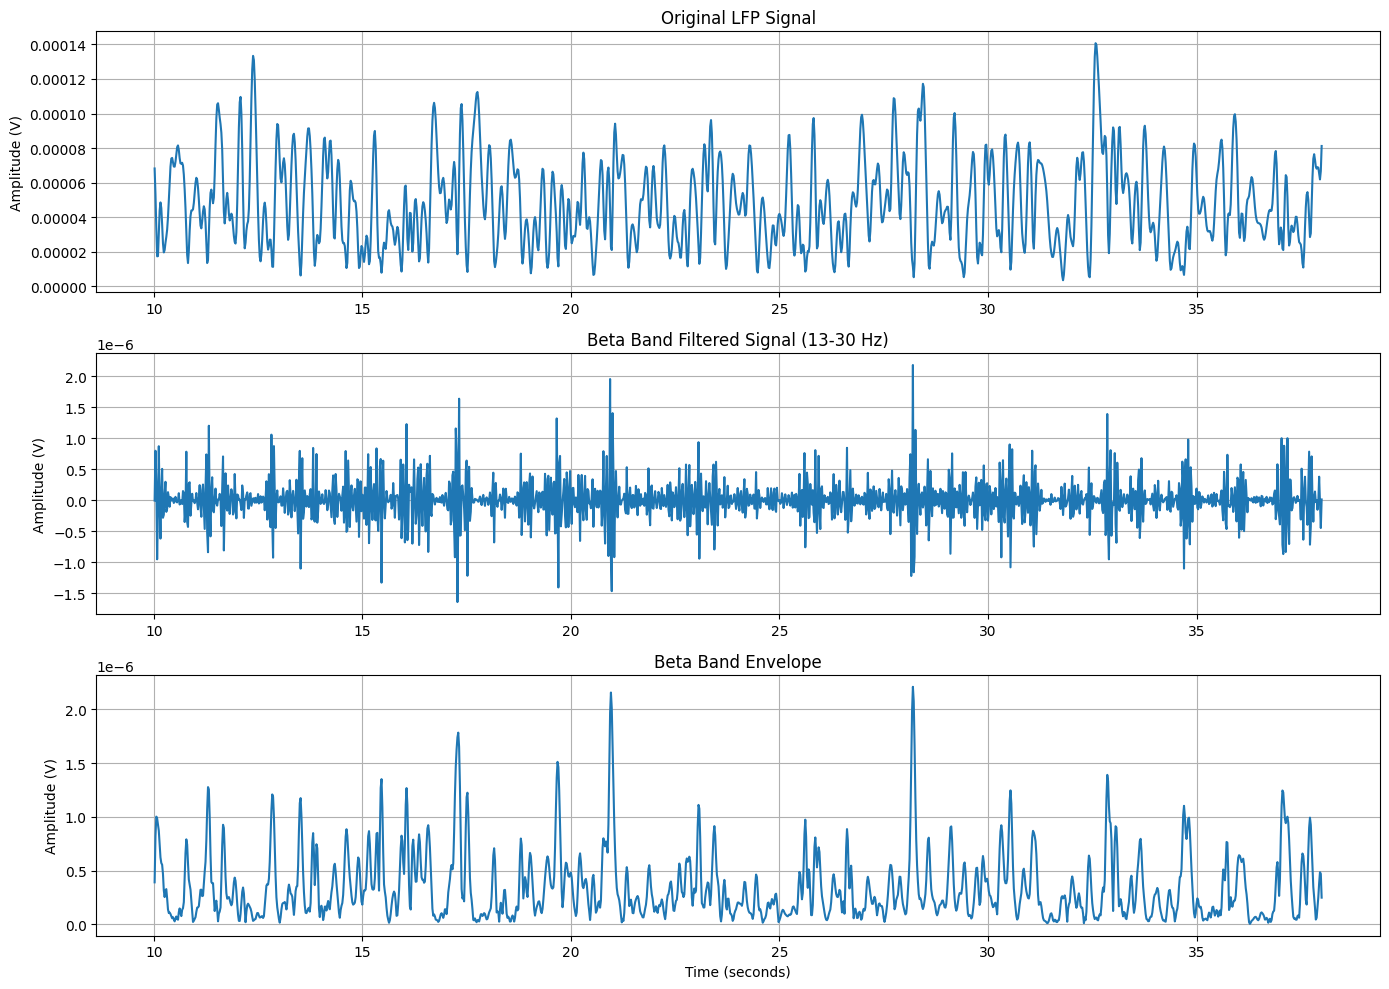

In [17]:
# Apply beta band filtering to the first dataset
ts = data_list[0]['timestamps']
fs = 1 / np.mean(np.diff(ts))

beta_filtered, beta_envelope = filter_and_envelope(data_list[0]['lfp_data'], fs, 13, 30)

# Plot original signal, filtered signal, and envelope
plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.plot(ts, data_list[0]['lfp_data'])
plt.title('Original LFP Signal')
plt.ylabel('Amplitude (V)')
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(ts, beta_filtered)
plt.title('Beta Band Filtered Signal (13-30 Hz)')
plt.ylabel('Amplitude (V)')
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(ts, beta_envelope)
plt.title('Beta Band Envelope')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (V)')
plt.grid(True)

plt.tight_layout()
plt.show()

### Comparison of Beta Envelopes Across Sessions

Finally, let's compare the beta envelopes across different sessions to see if there are differences in the temporal patterns of beta activity.

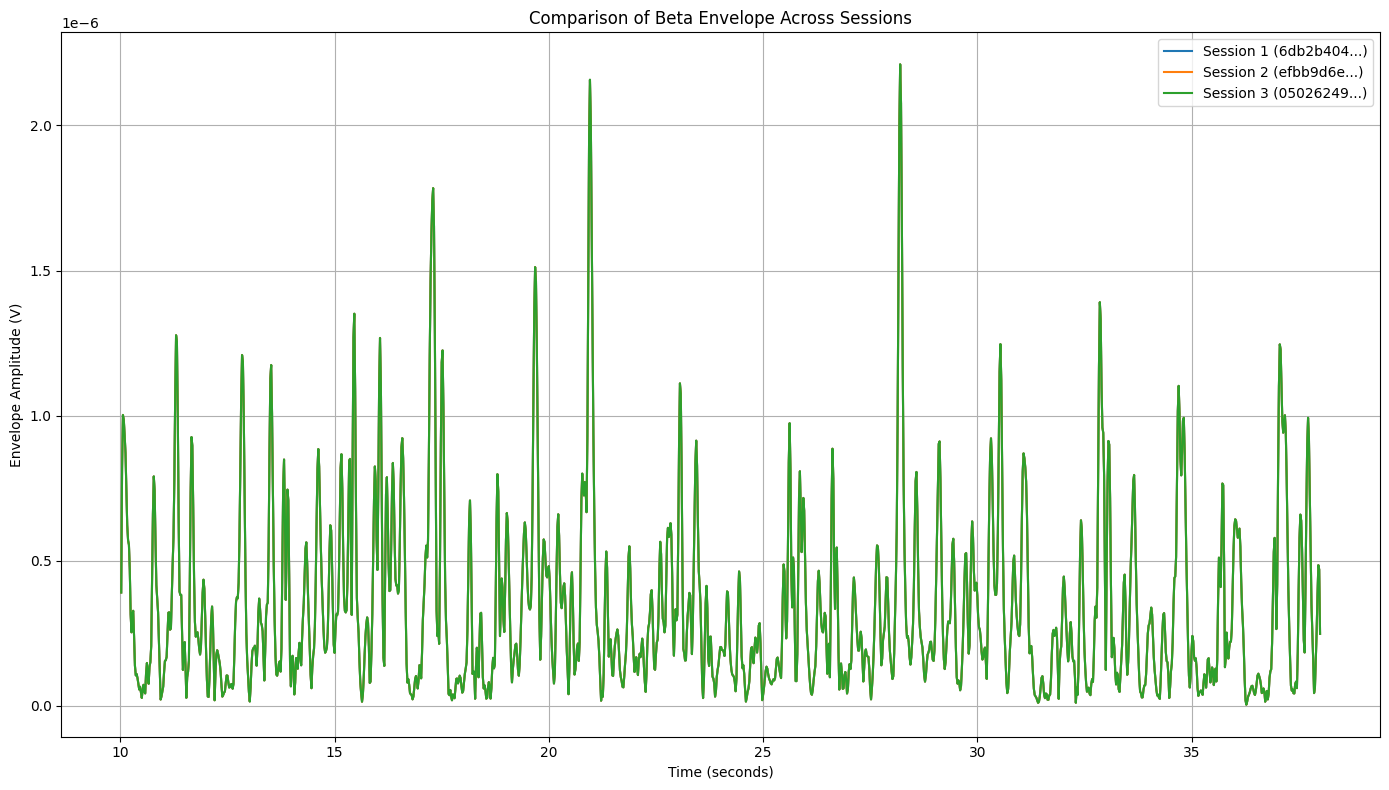

In [18]:
# Calculate beta envelopes for all sessions
envelopes = []

for idx, data in enumerate(data_list):
    # Calculate sampling frequency
    ts = data['timestamps']
    fs = 1 / np.mean(np.diff(ts))
    
    # Filter and get envelope
    _, envelope = filter_and_envelope(data['lfp_data'], fs, 13, 30)
    
    # Store information
    session_id = data['session_id'].split('-')[-1] if '-' in data['session_id'] else data['session_id']
    envelopes.append({
        'session_id': session_id[:8],
        'envelope': envelope,
        'timestamps': ts
    })

# Plot beta envelopes for comparison
plt.figure(figsize=(14, 8))

for idx, env_data in enumerate(envelopes):
    plt.plot(env_data['timestamps'], env_data['envelope'], 
             label=f"Session {idx+1} ({env_data['session_id']}...)")

plt.title('Comparison of Beta Envelope Across Sessions')
plt.xlabel('Time (seconds)')
plt.ylabel('Envelope Amplitude (V)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Summary

In this notebook, we've explored the Parkinson's Electrophysiological Signal Dataset (PESD), which contains simulated electrophysiological signals with beta oscillations. Key findings include:

1. The dataset consists of LFP data from simulated healthy subjects with beta oscillations.
2. Beta oscillations (13-30 Hz) are prominent in the signal, which is consistent with patterns observed in Parkinson's Disease.
3. The data structure includes information about the electrode groups, subject details, and the LFP signal data.
4. We've visualized the raw LFP signals, performed frequency analysis to identify the beta band power, and compared signals across different recording sessions.

This notebook serves as a starting point for more in-depth analyses of the dataset, which could include more sophisticated signal processing techniques, machine learning approaches, or correlation with clinical measures.

## Next Steps

Further analyses that could be performed on this dataset include:

1. Correlation between beta power and simulated clinical measures
2. Phase-amplitude coupling analysis to examine interactions between different frequency bands
3. Application of advanced signal processing techniques to identify characteristic patterns
4. Comparison with real patient data to validate the simulation parameters

Researchers should refer to the dataset's documentation and related publications for detailed information on the simulation parameters and the interpretation of the results.